# Import Module
- pandas
- sklearn
- matplotlib
- graphviz
- os
- seaborn

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.preprocessing import LabelEncoder
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns

## 1.2.1. Preparing the data sets

### Read data from 'nursery.data.csv' and shuffle the data

In [20]:
# Load the dataset
data = pd.read_csv("nursery.data.csv", names=["parents", "has_nurs", "form", "children", "housing", "finance", "social", "health", "class"])

# Shuffle the data and take it from top to bottom
# data_shuffled = shuffle(data)

### Split data in a stratified fashion
There will be experiments on training sets and test sets of different proportions, including (train/test) 40/60, 60/40, 80/20, and 90/10; thus, you need 16 subsets

In [21]:
# Function to prepare subsets
def prepare_subsets(data, train_ratio, test_ratio):
    # Split features and labels
    X = data.drop("class", axis=1)  # Exclude target attribute
    y = data["class"]
    
    # Split data into train and test sets
    feature_train, feature_test, label_train, label_test = train_test_split(X, y, train_size=train_ratio, test_size=test_ratio)
    
    return feature_train, feature_test, label_train, label_test

# Prepare subsets for different train/test proportions
proportions = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
subsets = {}

for train_ratio, test_ratio in proportions:
    key = f"{int(train_ratio*100)}/{int(test_ratio*100)}"
    subsets[key] = prepare_subsets(data, train_ratio, test_ratio)

Visualize the distributions of classes in all the data sets (the original set, training set, and test set) of all proportions to show that you have prepared them appropriately

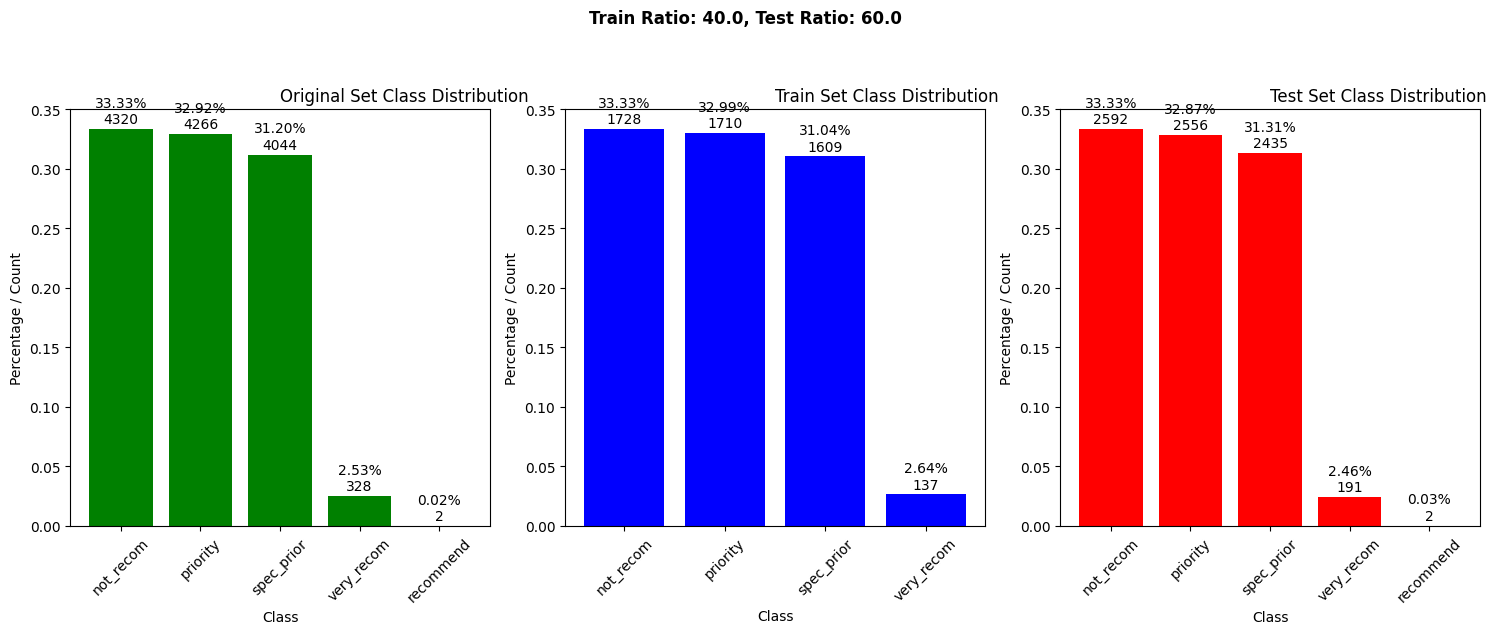

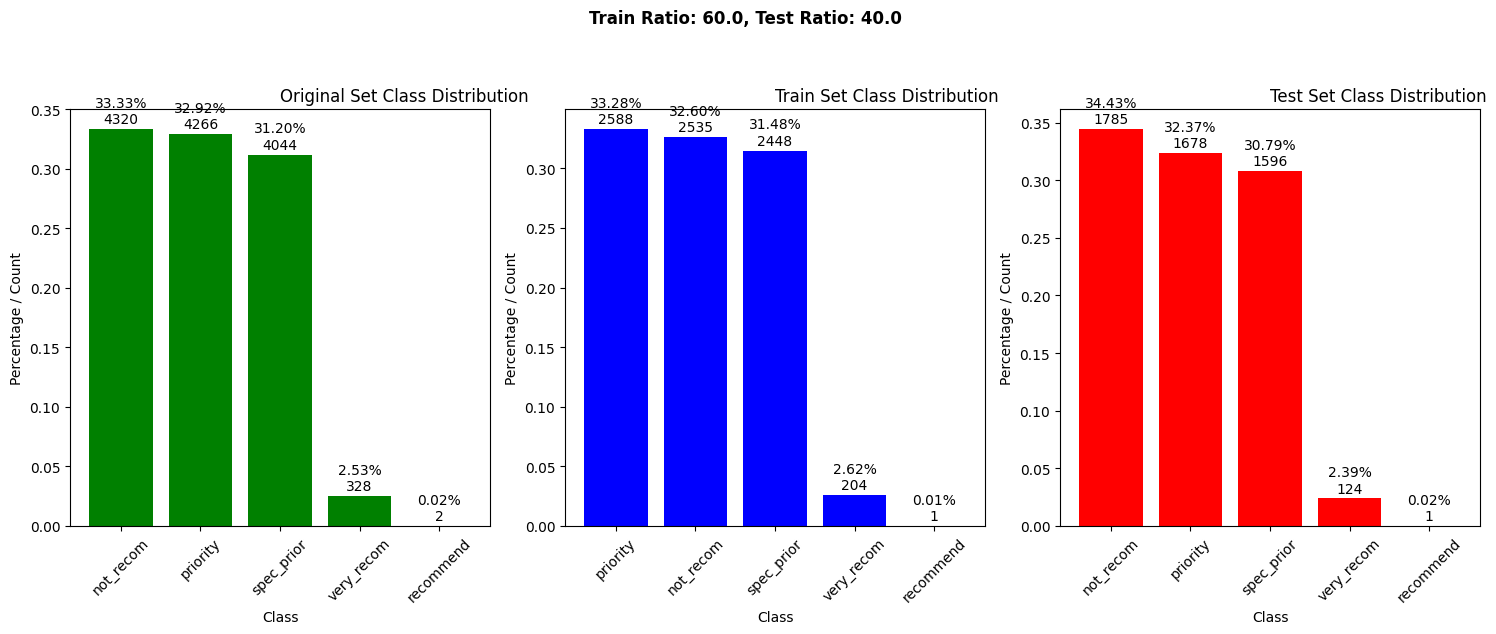

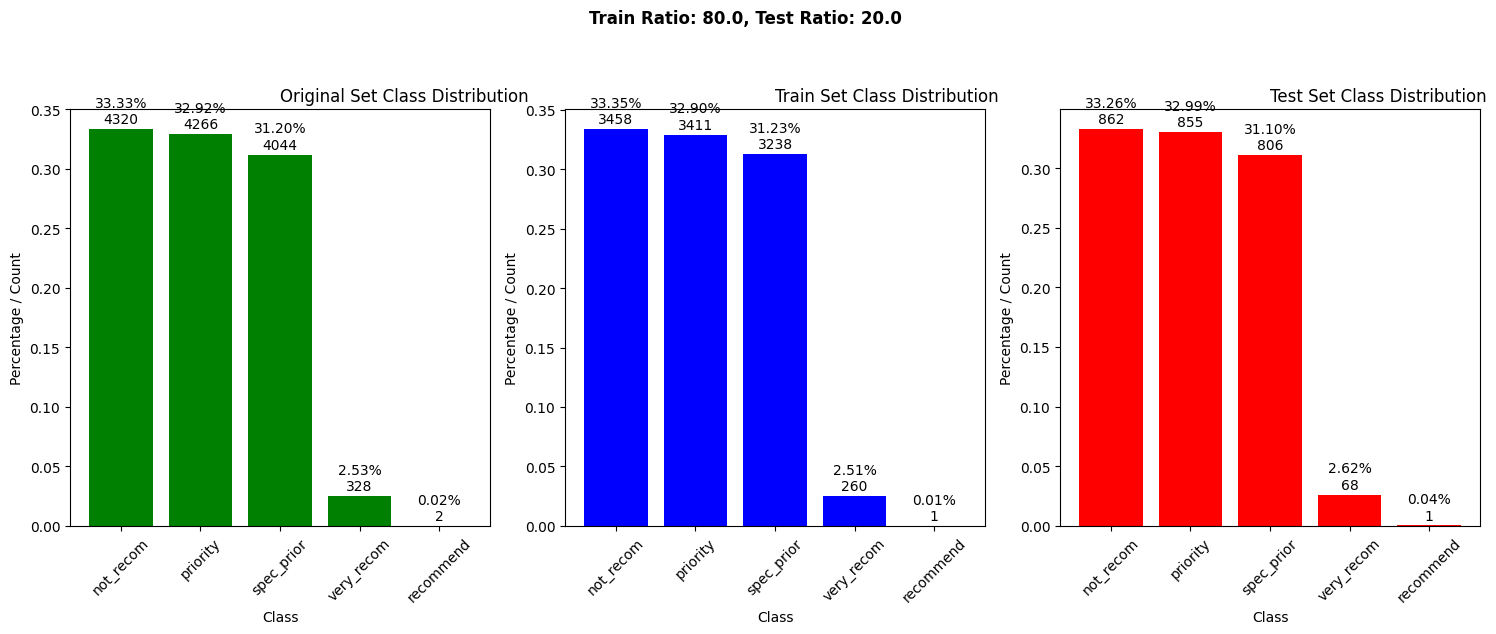

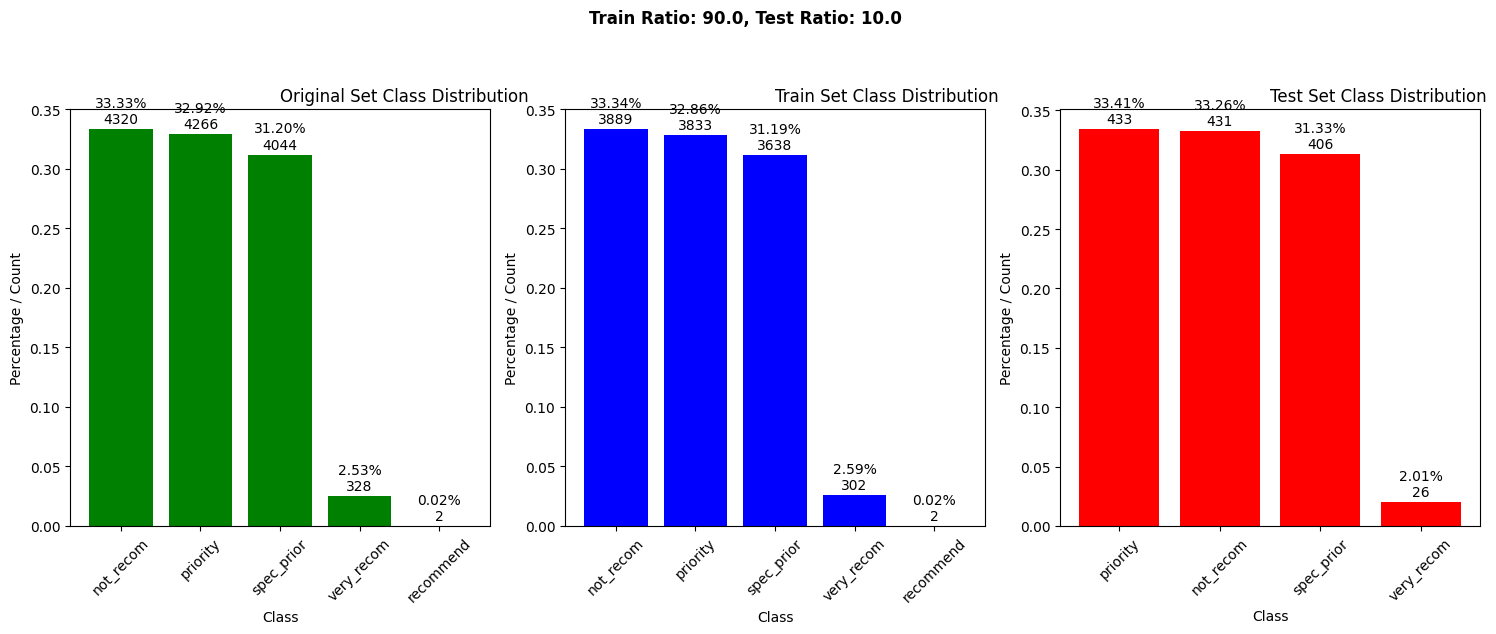

In [22]:
def visualize_class_distribution(train_label_data, test_label_data, original_label_data, title, train_ratio, test_ratio):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))  # Increase the width to accommodate the additional subplot

    train_class_counts = train_label_data.value_counts(normalize=True)
    test_class_counts = test_label_data.value_counts(normalize=True)
    original_class_counts = original_label_data.value_counts(normalize=True)

    ax[0].bar(original_class_counts.index, original_class_counts.values, color='g')
    ax[0].set_title('Original Set Class Distribution', ha='left')
    ax[0].set_xlabel('Class')
    ax[0].set_ylabel('Percentage / Count')
    ax[0].tick_params(axis='x', rotation=45)

    ax[1].bar(train_class_counts.index, train_class_counts.values, color='b')
    ax[1].set_title('Train Set Class Distribution', ha='left')
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Percentage / Count')
    ax[1].tick_params(axis='x', rotation=45)

    ax[2].bar(test_class_counts.index, test_class_counts.values, color='r')
    ax[2].set_title('Test Set Class Distribution', ha='left')
    ax[2].set_xlabel('Class')
    ax[2].set_ylabel('Percentage / Count')
    ax[2].tick_params(axis='x', rotation=45)


    # Display percentage values and counts on top of each bar
    for i, (v, count) in enumerate(zip(original_class_counts.values, original_label_data.value_counts())):
        ax[0].text(i, v + 0.005, f"{v*100:.2f}%\n{count}", ha='center', color='black')

    for i, (v, count) in enumerate(zip(train_class_counts.values, train_label_data.value_counts())):
        ax[1].text(i, v + 0.005, f"{v*100:.2f}%\n{count}", ha='center', color='black')

    for i, (v, count) in enumerate(zip(test_class_counts.values, test_label_data.value_counts())):
        ax[2].text(i, v + 0.005, f"{v*100:.2f}%\n{count}", ha='center', color='black')


    # Add train and test ratios on top of the image
    fig.suptitle(f'Train Ratio: {train_ratio}, Test Ratio: {test_ratio}', fontsize=12, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

for key, (feature_train, feature_test, label_train, label_test) in subsets.items():
    visualize_class_distribution(label_train, label_test, data["class"], "Class Distributions", *map(float, key.split("/")))
    print()

## 1.2.2 Building the decision tree classifiers
This task conducts experiments on the designated train/test proportions listed above.

You need to fit an instance of sklearn.tree.DecisionTreeClassifier (with information gain) to each training set and
visualize the resulting decision tree using graphviz.

NOTE: I split the decision tree at each depth for easier reading and saved the resulting trees in the folder named 'Decision_Tree_Results'

In [23]:
# Create a directory to store the decision tree outputs
output_directory = "Decision_Tree_Results"
os.makedirs(output_directory, exist_ok=True)

list_decision_tree = {}

def fit_and_visualize_decision_tree(feature_train, label_train, train_ratio, test_ratio):
    
    # Initialize and fit the decision tree classifier
    decision_tree = DecisionTreeClassifier(criterion="entropy")

    feature_train_encoded = pd.get_dummies(feature_train)

    decision_tree.fit(feature_train_encoded, label_train)

    key = f"{int(train_ratio*100)}/{int(test_ratio*100)}"
    list_decision_tree[key] = decision_tree
    
    # Get the maximum depth of the decision tree
    max_depth = decision_tree.tree_.max_depth
        
    # Create a directory for the current case
    case_directory = os.path.join(output_directory, f"Decision_Tree_Train_Test_Ratio_{int(train_ratio*100)}_{int(test_ratio*100)}")
    os.makedirs(case_directory, exist_ok=True)
    
    # Visualize each depth of the decision tree
    for depth in range(1, max_depth + 1):
        # Set the maximum depth of the tree
        decision_tree.max_depth = depth

        # Encode categorical features using one-hot encoding
        feature_train_encoded = pd.get_dummies(feature_train)
        
        # Fit the decision tree classifier
        decision_tree.fit(feature_train_encoded, label_train)
        
        # Visualize the decision tree and save it to the case directory
        dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_train_encoded.columns, class_names=decision_tree.classes_, filled=True, rounded=True)
        graph = graphviz.Source(dot_data)
        
        if depth == max_depth:
            graph.render(os.path.join(case_directory, f"Decision_tree_depth_final_result"))
        else:
            graph.render(os.path.join(case_directory, f"Decision_tree_with_depth_{depth}"))
    
    return decision_tree


# Loop through each train/test proportion
for train_ratio, test_ratio in proportions:
    key = f"{int(train_ratio*100)}/{int(test_ratio*100)}"
    
    # Retrieve the training data for the current proportion
    feature_train, _, label_train, _ = subsets[key]
    
    # Fit and visualize the decision tree for each depth
    decision_tree = fit_and_visualize_decision_tree(feature_train, label_train, train_ratio, test_ratio)
    print(f"Train/Test Ratio: {key} is fitted and visualized in folder {output_directory} > Decision_Tree_Train_Test_Ratio_{int(train_ratio*100)}_{int(test_ratio*100)}")


Train/Test Ratio: 40/60 is fitted and visualized in folder Decision_Tree_Results > Decision_Tree_Train_Test_Ratio_40_60
Train/Test Ratio: 60/40 is fitted and visualized in folder Decision_Tree_Results > Decision_Tree_Train_Test_Ratio_60_40
Train/Test Ratio: 80/20 is fitted and visualized in folder Decision_Tree_Results > Decision_Tree_Train_Test_Ratio_80_20
Train/Test Ratio: 90/10 is fitted and visualized in folder Decision_Tree_Results > Decision_Tree_Train_Test_Ratio_90_10


## 1.2.3 Evaluating the decision tree classifiers

For each of the above decision tree classifiers, predict the examples in the corresponding test set, and make a report
using classification_report and confusion_matrix.

Classification Report with rain/Test Ratio: 40/60:
              precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00      2592
    priority       0.98      0.98      0.98      2556
   recommend       1.00      0.00      0.00         2
  spec_prior       0.98      0.98      0.98      2435
  very_recom       0.96      1.00      0.98       191

    accuracy                           0.99      7776
   macro avg       0.98      0.79      0.79      7776
weighted avg       0.99      0.99      0.99      7776

Confusion Matrix with train/Test Ratio: 40/60:


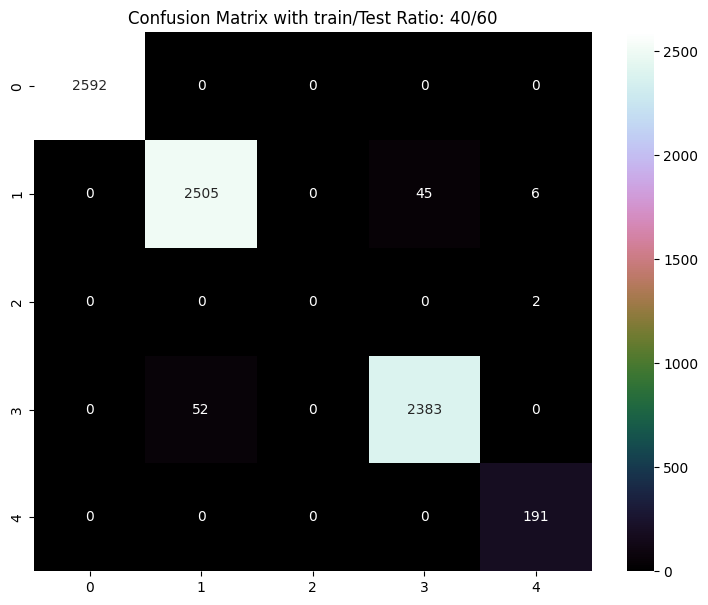


Classification Report with rain/Test Ratio: 60/40:
              precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00      1785
    priority       0.99      0.99      0.99      1678
   recommend       0.33      1.00      0.50         1
  spec_prior       0.99      0.99      0.99      1596
  very_recom       0.97      0.98      0.98       124

    accuracy                           0.99      5184
   macro avg       0.86      0.99      0.89      5184
weighted avg       1.00      0.99      0.99      5184

Confusion Matrix with train/Test Ratio: 60/40:


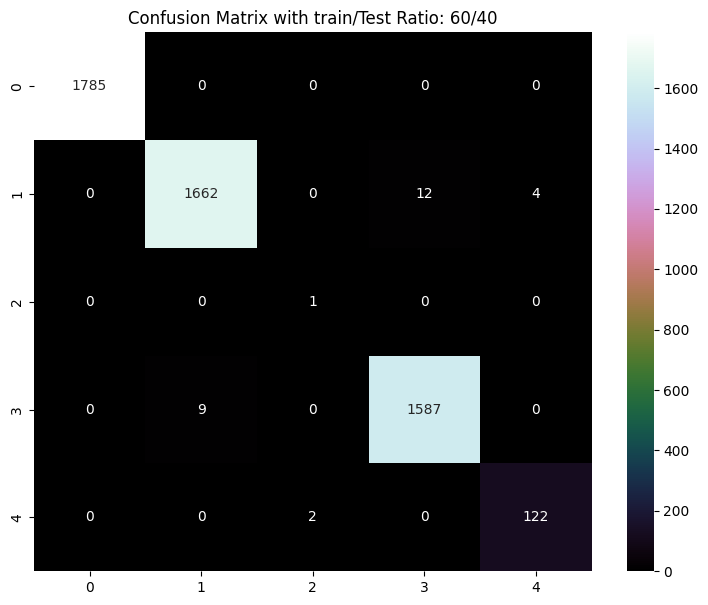


Classification Report with rain/Test Ratio: 80/20:
              precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00       862
    priority       0.99      1.00      0.99       855
   recommend       0.00      0.00      0.00         1
  spec_prior       1.00      0.99      0.99       806
  very_recom       0.99      0.99      0.99        68

    accuracy                           1.00      2592
   macro avg       0.79      0.79      0.79      2592
weighted avg       1.00      1.00      1.00      2592

Confusion Matrix with train/Test Ratio: 80/20:


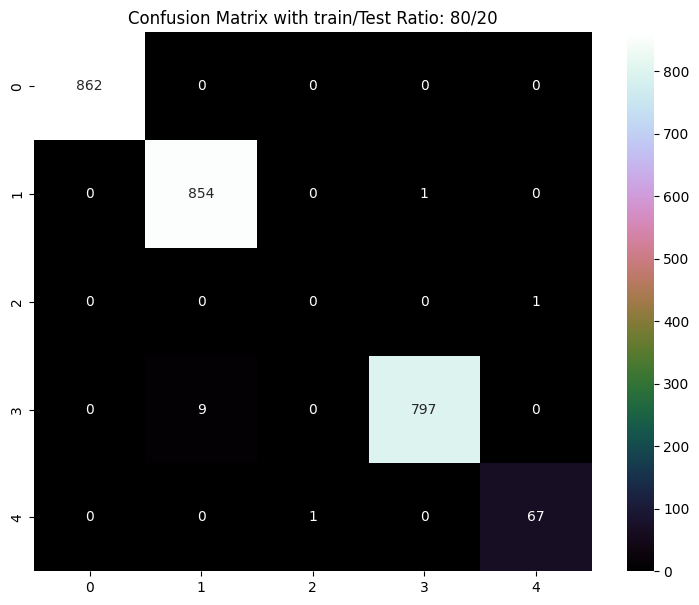


Classification Report with rain/Test Ratio: 90/10:
              precision    recall  f1-score   support

   not_recom       1.00      1.00      1.00       431
    priority       1.00      1.00      1.00       433
  spec_prior       1.00      1.00      1.00       406
  very_recom       1.00      1.00      1.00        26

    accuracy                           1.00      1296
   macro avg       1.00      1.00      1.00      1296
weighted avg       1.00      1.00      1.00      1296

Confusion Matrix with train/Test Ratio: 90/10:


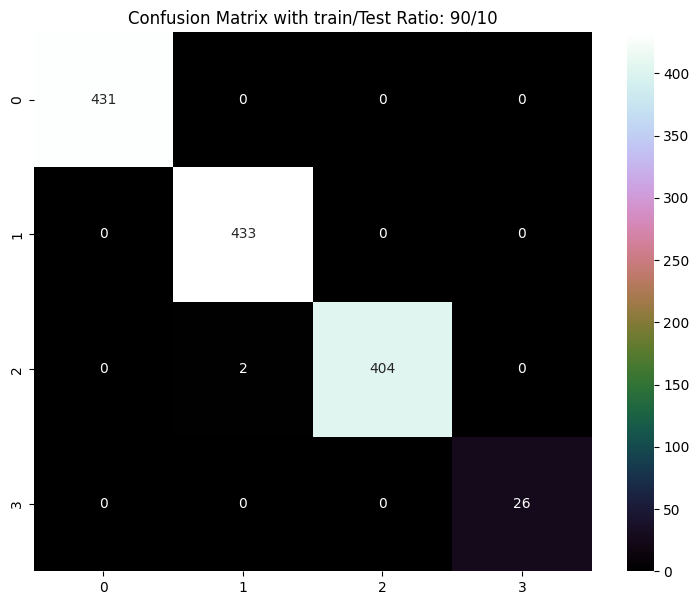

In [24]:
def evaluate_decision_tree_classifier(decision_tree, feature_test, label_test):
    # Make predictions on the test set
    predictions = decision_tree.predict(feature_test)
    
    # Generate classification report and confusion matrix
    report = classification_report(label_test, predictions, zero_division=1)
    matrix = confusion_matrix(label_test, predictions)
    
    return report, matrix

# Loop through each train/test proportion
for train_ratio, test_ratio in proportions:
    key = f"{int(train_ratio*100)}/{int(test_ratio*100)}"
    
    # Retrieve the training and test data for the current proportion
    feature_train, feature_test, label_train, label_test = subsets[key]
    
    # Encode categorical features
    feature_train_encoded = pd.get_dummies(feature_train)
    feature_test_encoded = pd.get_dummies(feature_test)
    
    # Evaluate the decision tree classifier on test data
    key = f"{int(train_ratio*100)}/{int(test_ratio*100)}"
    report, matrix = evaluate_decision_tree_classifier(list_decision_tree[key], feature_test_encoded, label_test)
    
    # Print the results
    print(f"Classification Report with rain/Test Ratio: {key}:")
    print(report)

    print(f"Confusion Matrix with train/Test Ratio: {key}:")
    plt.figure(figsize=(9, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='cubehelix')
    plt.title(f'Confusion Matrix with train/Test Ratio: {key}')
    plt.show()

    print()

    

## 1.2.4 The depth and accuracy of a decision tree

This task works on the 80/20 training set and test set. You need to consider how the decision tree’s depth affects the classification accuracy.

You can specify the maximum depth of a decision tree by varying the parameter max_depth of the decision tree.

You need to try the following values for parameter max_depth: None, 2, 3, 4, 5, 6, 7. And then,

### Provide the decision tree drawn by graphviz for each max_depth value

In [25]:
list_accuracy = []
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
result_folder = "Decision_Tree_80_20_1.2.4"

def the_depth_and_accuracy_of_decision_tree(train_ratio, test_ratio):
    key = f"{int(train_ratio*100)}/{int(test_ratio*100)}"
    feature_train, feature_test, label_train, label_test = subsets[key]

    feature_train_encoded = pd.get_dummies(feature_train)
    feature_test_encoded = pd.get_dummies(feature_test)

    for depth in max_depth_values:
        
        decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)

        # Train the classifier on the encoded training data
        decision_tree.fit(feature_train_encoded, label_train)

        predictions = decision_tree.predict(feature_test_encoded)

        accuracy = accuracy_score(label_test, predictions)
        list_accuracy.append(accuracy)

        dot_data = export_graphviz(decision_tree, out_file=None,
                               feature_names=feature_train_encoded.columns,
                               class_names=decision_tree.classes_,
                               filled=True,
                               rounded=True,
                               special_characters=True)

        # Create a Graphviz object and render it as a PNG file
        graph = graphviz.Source(dot_data)
        graph.render(os.path.join(result_folder, f"Decision_tree_with_depth_{depth}"))

    
    print(f"The Decision Tree drawn by graphviz for each max_depth value of Train/Test Ratio: {key} in folder {result_folder}")
    
the_depth_and_accuracy_of_decision_tree(proportions[2][0], proportions[2][1])

The Decision Tree drawn by graphviz for each max_depth value of Train/Test Ratio: 80/20 in folder Decision_Tree_80_20_1.2.4


### Report to the following table the accuracy_score (on the test set) of the decision tree classifier when changing the value of parameter max_depth.

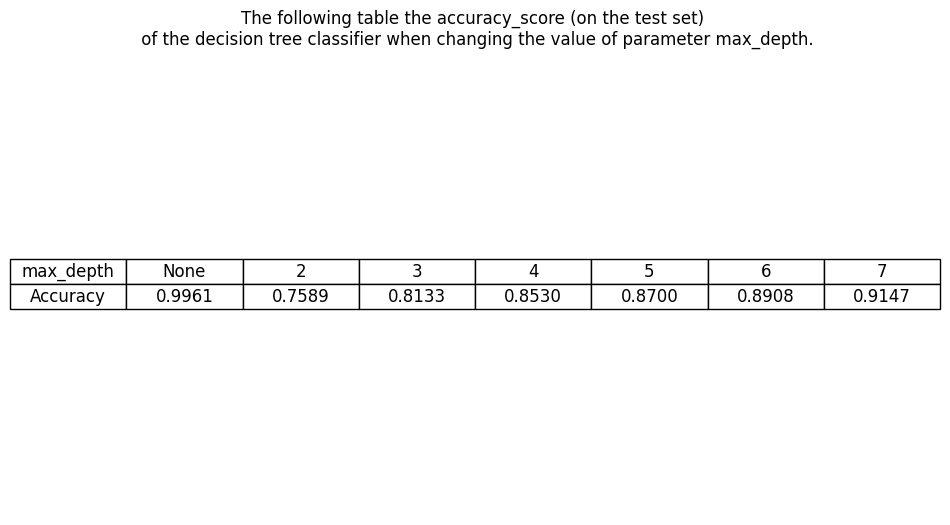

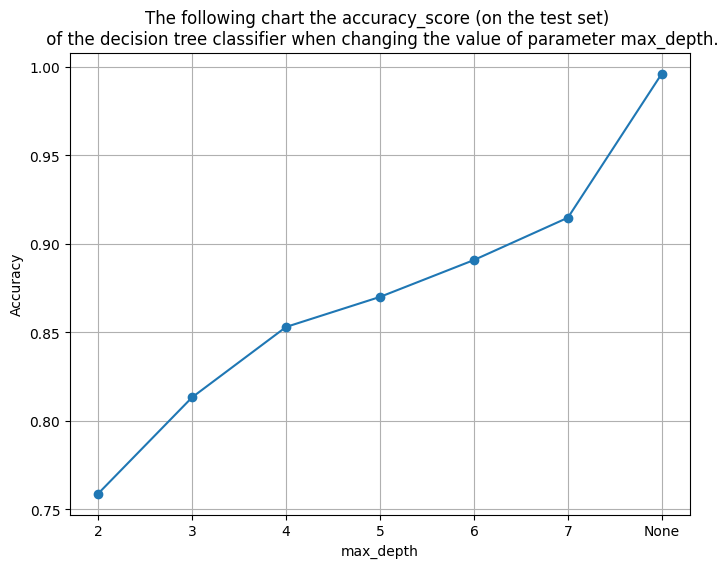

In [26]:
plt.figure(figsize=(10, 6))
plt.title('The following table the accuracy_score (on the test set) \n of the decision tree classifier when changing the value of parameter max_depth.')
plt.axis('off')  # Hide the axes

# Construct table data
table_data = [["max_depth", "Accuracy"]]
for depth, accuracy in zip(max_depth_values, list_accuracy):
    table_data.append([str(depth), f"{accuracy:.4f}"])

# Transpose the table data
table_data_transposed = list(zip(*table_data))

# Create the table
table = plt.table(cellText=table_data_transposed, loc='center', cellLoc='center', colWidths=[0.1]*8)
table.set_fontsize(12)
table.scale(1.5, 1.5)  # Adjust the scale of the table for better readability

plt.show()

max_depth_values_reordered = max_depth_values[1:] + [str(max_depth_values[0])]
accuracy_reordered = list_accuracy[1:] + [list_accuracy[0]]

plt.figure(figsize=(8, 6))
plt.plot(max_depth_values_reordered, accuracy_reordered, marker='o', linestyle='-')
plt.title('The following chart the accuracy_score (on the test set) \n of the decision tree classifier when changing the value of parameter max_depth.')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

### Make your comment on the above statistics.

In [27]:
def analyze_accuracy(max_depth_values, list_accuracy):
    # Find the index of the maximum accuracy
    max_accuracy_index = list_accuracy.index(max(list_accuracy))
    max_accuracy_depth = max_depth_values[max_accuracy_index]

    # Find the index of the minimum accuracy
    min_accuracy_index = list_accuracy.index(min(list_accuracy))
    min_accuracy_depth = max_depth_values[min_accuracy_index]

    # Calculate the average accuracy
    avg_accuracy = sum(list_accuracy) / len(list_accuracy)

    # Check if accuracy improves with depth
    accuracy_improves = all(list_accuracy[i] <= list_accuracy[i + 1] <= list_accuracy[0] for i in range(1, len(list_accuracy) - 1))

    # Generate comments based on the analysis
    comments = []
    comments.append(f"The maximum accuracy of {max(list_accuracy):.4f} is achieved at max_depth={max_accuracy_depth}.")
    comments.append(f"The minimum accuracy of {min(list_accuracy):.4f} is achieved at max_depth={min_accuracy_depth}.")
    comments.append(f"The average accuracy across all depths is {avg_accuracy:.4f}.")
    if accuracy_improves:
        comments.append("The accuracy generally improves with increasing max_depth.")
    else:
        comments.append("The accuracy does not consistently improve with increasing max_depth.")

    return comments

comments = analyze_accuracy(max_depth_values, list_accuracy)

for comment in comments:
    print(comment)


The maximum accuracy of 0.9961 is achieved at max_depth=None.
The minimum accuracy of 0.7589 is achieved at max_depth=2.
The average accuracy across all depths is 0.8710.
The accuracy generally improves with increasing max_depth.
